In [5]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [6]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

In [7]:
train_labels = train_transaction[["TransactionID","isFraud"]]

In [8]:
train_transaction = train_transaction.merge(train_identity,on="TransactionID",how='outer')
test_transaction = test_transaction.merge(test_identity,on="TransactionID",how='outer')

In [9]:
test_transaction.columns = test_transaction.columns.str.replace('id-','id_')

In [10]:
test_transaction = test_transaction[["TransactionID","TransactionDT","TransactionAmt","ProductCD","card1","card2","card3","card4","card5","card6",\
                          "addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain","M1","M2","M3","M4","M5",\
                          "M6","M7","M8","M9","C1","C2","C3","C4","C5","C6","C7",\
                          "C8","C9","C10","C11","C12","C13","C14","D1","D2","D3","D4",\
                          "D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15",\
                          "V15","V29","V30","V32","V33","V44","V45","V56","V57","V58",\
                          "V65","V69","V70","V72","V88","V90","V91","V102","V124","V149","V154",\
                          "V156","V186","V187","V188","V189","V194","V195","V200","V201","V242","V243",\
                          "V244","V245","V246","V257","V258","V268","V283","V294","V295","V302","V324",\
                          "id_01","id_02","id_03","id_04","id_05","id_06","id_07","id_08","id_09","id_10","id_11",\
                          "id_12","id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22",\
                          "id_23","id_24","id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32",\
                          "id_33","id_34","id_35","id_36","id_37","id_38","DeviceType","DeviceInfo"]]

train_transaction = train_transaction[["TransactionID","isFraud","TransactionDT","TransactionAmt","ProductCD","card1","card2","card3","card4","card5","card6",\
                          "addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain","M1","M2","M3","M4","M5",\
                          "M6","M7","M8","M9","C1","C2","C3","C4","C5","C6","C7",\
                          "C8","C9","C10","C11","C12","C13","C14","D1","D2","D3","D4",\
                          "D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15",\
                          "V15","V29","V30","V32","V33","V44","V45","V56","V57","V58",\
                          "V65","V69","V70","V72","V88","V90","V91","V102","V124","V149","V154",\
                          "V156","V186","V187","V188","V189","V194","V195","V200","V201","V242","V243",\
                          "V244","V245","V246","V257","V258","V268","V283","V294","V295","V302","V324",\
                          "id_01","id_02","id_03","id_04","id_05","id_06","id_07","id_08","id_09","id_10","id_11",\
                          "id_12","id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22",\
                          "id_23","id_24","id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32",\
                          "id_33","id_34","id_35","id_36","id_37","id_38","DeviceType","DeviceInfo"]]



In [11]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [12]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_transaction = pd.get_dummies(train_transaction, columns =['ProductCD','card6' ])
test_transaction = pd.get_dummies(test_transaction, columns =['ProductCD','card6' ])

In [14]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,addr1,...,DeviceInfo,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0,86400,68.5,13926,NaN,150.0,discover,142.0,315.0,...,NaN,0,0,0,0,1,0,1,0,0
1,2987001,0,86401,29.0,2755,404.0,150.0,mastercard,102.0,325.0,...,NaN,0,0,0,0,1,0,1,0,0
2,2987002,0,86469,59.0,4663,490.0,150.0,visa,166.0,330.0,...,NaN,0,0,0,0,1,0,0,1,0
3,2987003,0,86499,50.0,18132,567.0,150.0,mastercard,117.0,476.0,...,NaN,0,0,0,0,1,0,0,1,0
4,2987004,0,86506,50.0,4497,514.0,150.0,mastercard,102.0,420.0,...,SAMSUNG SM-G892A Build/NRD90M,0,1,0,0,0,0,1,0,0


In [15]:
categorias = train_transaction[['isFraud', 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5', 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38']]

train_transaction = train_transaction.drop(columns =[ 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5', 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38'] )

In [16]:
categorias.head()

,isFraud,card1,card2,card3,card4,card5,addr1,addr2,P_emaildomain,R_emaildomain,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,0,13926,NaN,150.0,discover,142.0,315.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2755,404.0,150.0,mastercard,102.0,325.0,87.0,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,4663,490.0,150.0,visa,166.0,330.0,87.0,outlook.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,18132,567.0,150.0,mastercard,117.0,476.0,87.0,yahoo.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4497,514.0,150.0,mastercard,102.0,420.0,87.0,gmail.com,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [17]:
for (columnName, columnData) in categorias.iteritems():
    if columnName != 'isFraud':
       aux = categorias.groupby([columnName])['isFraud'].mean().to_dict()
       categorias[columnName] =  categorias[columnName].map(aux)
       test_transaction[columnName] = test_transaction[columnName].map(aux)

In [18]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="mean",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(train_transaction))
idf.columns=train_transaction.columns
idf.index=train_transaction.index

In [19]:
train_transaction = idf

In [20]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_11,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000.0,0.0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,...,99.745325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2987001.0,0.0,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,99.745325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2987002.0,0.0,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,...,99.745325,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2987003.0,0.0,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,...,99.745325,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2987004.0,0.0,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,100.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
categorias = categorias.drop(columns =["isFraud"] )

In [22]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="most_frequent",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(categorias))
idf.columns=categorias.columns
idf.index=categorias.index

In [23]:
categorias = idf

In [24]:
train_transaction = train_transaction.join(categorias)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,2987000.0,0.0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,2987001.0,0.0,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,2987002.0,0.0,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,2987003.0,0.0,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,2987004.0,0.0,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,0.051338,0.057820,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [25]:
#df_test_encoding = df_test_encoding.iloc[:,1:]
X = train_transaction.iloc[:, 2:]
y = train_labels.iloc[:, 1:]

In [26]:
X.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,0.0,4.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.051338,0.057820,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [28]:
#MODELO 1
xgb_cl = xgb.XGBClassifier(min_child_weight= 5, 
                           learning_rate= 0.1, 
                           gamma= 0.05, 
                           subsample= 0.8,
                           colsample_bytree= 0.3, 
                           colsample_bynode= 0.8,
                           colsample_bylevel= 0.8, 
                           max_depth = 20, 
                           n_estimators = 150)

In [ ]:
 param_grid = {
        "max_depth": [3,10,20],
        "learning_rate": [0.1,0.05],
        "gamma": [0.05,0.25],
 }

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


_ = grid_cv.fit(X_train,y_train)
xgb_cl.fit(X_train,y_train)

In [29]:
xgb_cl.fit(X_train,y_train)

C:\Users\Pato\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Pato\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.3, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
pred_xgboost = xgb_cl.predict(X_test)

In [31]:
xgb_cl.feature_importances_

array([0.00316276, 0.00313103, 0.00335839, 0.00271937, 0.00683795,
       0.0043926 , 0.00744971, 0.01734347, 0.00613299, 0.00456835,
       0.00602118, 0.00738682, 0.00404647, 0.0048571 , 0.00678312,
       0.00842592, 0.00736074, 0.01031078, 0.0036213 , 0.00441448,
       0.00320619, 0.00319289, 0.00267914, 0.00350367, 0.00312162,
       0.00306681, 0.00208959, 0.00327204, 0.0027447 , 0.0030613 ,
       0.00343257, 0.0024455 , 0.00300484, 0.00673157, 0.01007578,
       0.00720401, 0.00759715, 0.00370336, 0.00672321, 0.00508951,
       0.00389812, 0.0072672 , 0.00558545, 0.00876235, 0.00925933,
       0.00962956, 0.00536408, 0.00258207, 0.00589835, 0.00855048,
       0.00651784, 0.00507076, 0.01260442, 0.00647579, 0.01467196,
       0.00430043, 0.00774394, 0.01091441, 0.03682317, 0.00586131,
       0.006736  , 0.03230681, 0.02294025, 0.00648336, 0.02874804,
       0.03143533, 0.00266351, 0.03359612, 0.06252962, 0.03595827,
       0.00531774, 0.00758327, 0.0103609 , 0.00652176, 0.00229

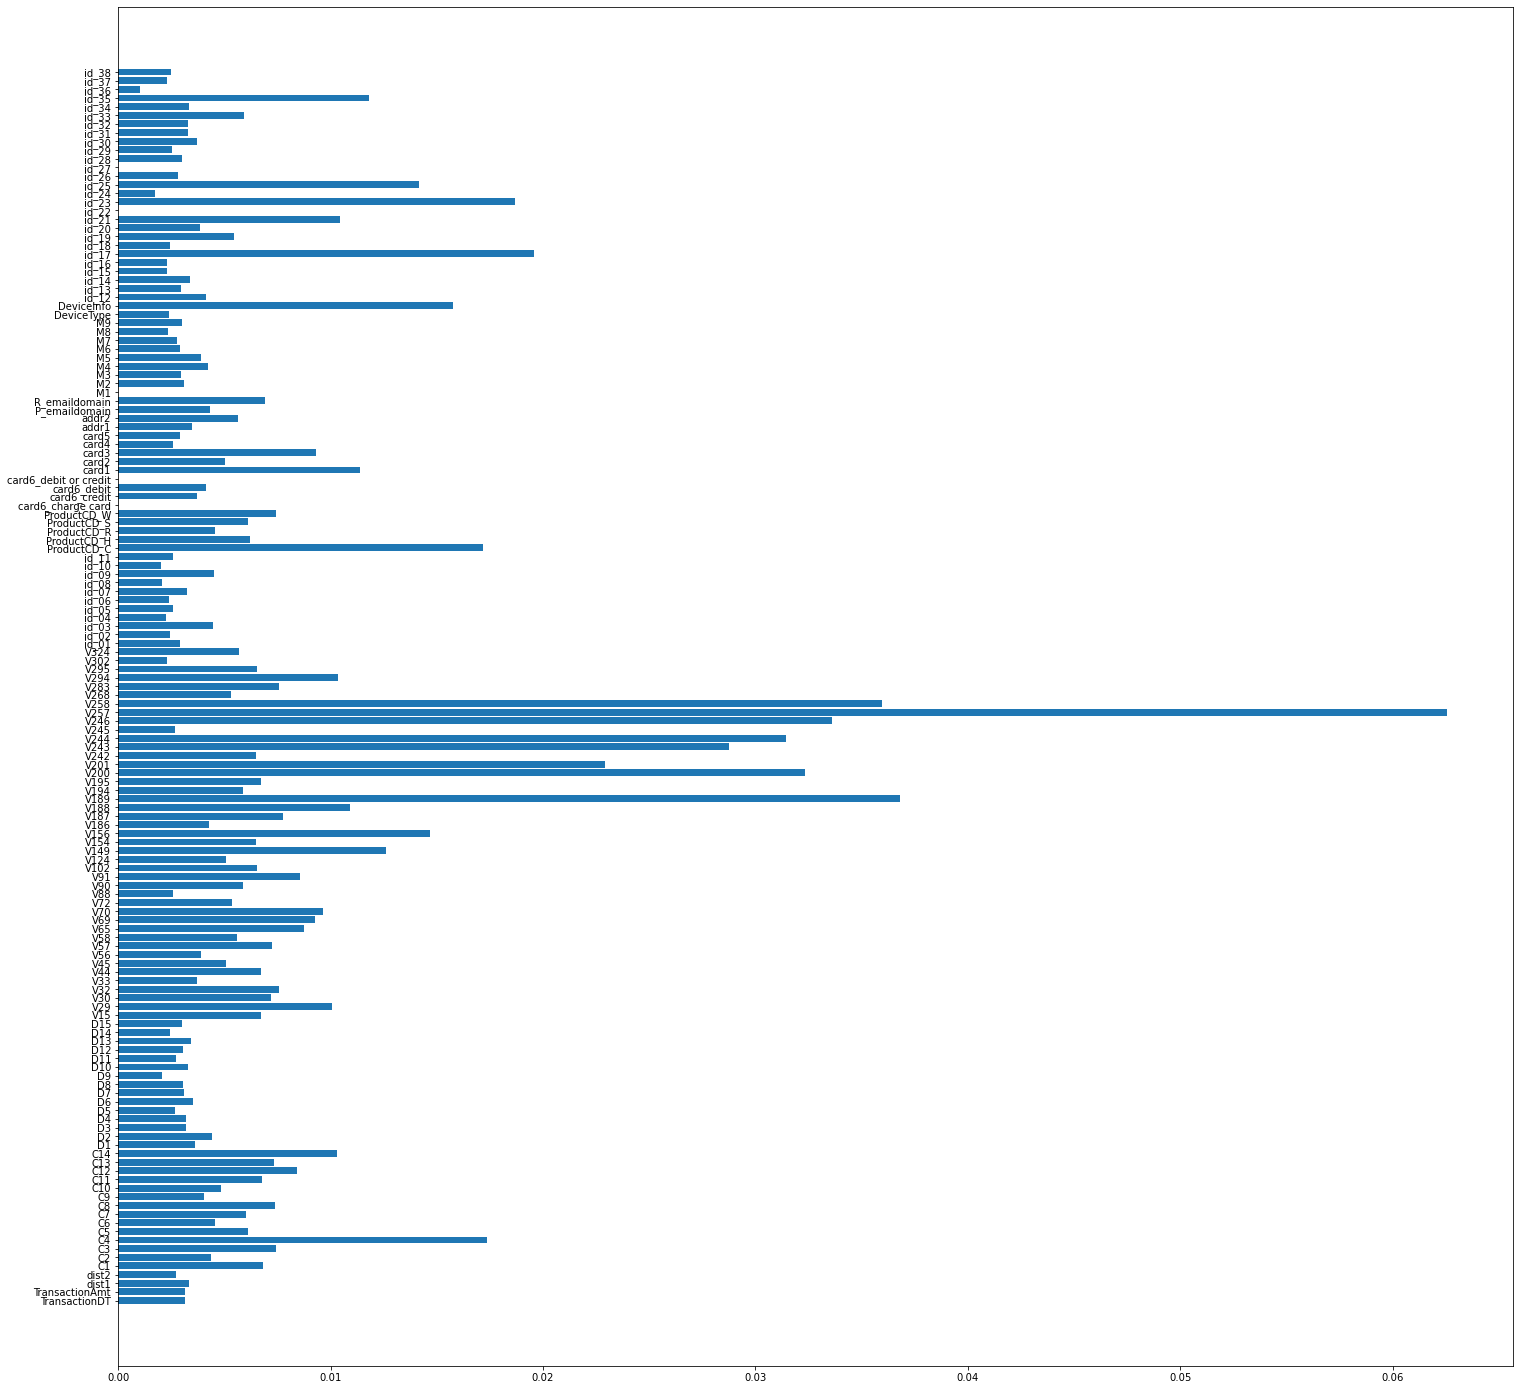

In [32]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, xgb_cl.feature_importances_)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, xgb_cl.predict_proba(X_test)[:,1])
print(auc)

0.9752381431450566


In [34]:
print(roc_auc_score(train_labels["isFraud"], xgb_cl.predict_proba(X)[:,1]))


0.9920072666183106


In [ ]:
########################################################################################
########################################################################################

In [48]:
#MODELO 2
lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference= lgb_train)

AttributeError: type object 'LGBMClassifier' has no attribute 'Dataset'

In [35]:
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_classes': 3,
    'num_leaves': 40,
    'learning_rate': 0.05,
    'max_depth': 8
}

In [36]:
model = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12291
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 140
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.035377
[LightGBM] [Info] Start training from score -3.359333
[LightGBM] [Info] Start training from score -34.538776
[1]	valid_0's multi_logloss: 0.13336
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.125938
[3]	valid_0's multi_logloss: 0.120632
[4]	valid_0's multi_logloss: 0.116454
[5]	valid_0's multi_logloss: 0.112846
[6]	valid_0's multi_logloss: 0.109932
[7]	valid_0's multi_logloss: 0

[189]	valid_0's multi_logloss: 0.0642334
[190]	valid_0's multi_logloss: 0.0641985
[191]	valid_0's multi_logloss: 0.0641771
[192]	valid_0's multi_logloss: 0.0641232
[193]	valid_0's multi_logloss: 0.0641041
[194]	valid_0's multi_logloss: 0.064066
[195]	valid_0's multi_logloss: 0.0639731
[196]	valid_0's multi_logloss: 0.0639467
[197]	valid_0's multi_logloss: 0.0638904
[198]	valid_0's multi_logloss: 0.063848
[199]	valid_0's multi_logloss: 0.0638091
[200]	valid_0's multi_logloss: 0.0637776
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 0.0637776


In [37]:
pred = model.predict(X_test)

In [38]:
labels_pred = [np.argmax(v) + 1 for v in pred]
len(labels_pred)

118108

In [39]:
print(roc_auc_score (y_test, pred[:,1],multi_class='ovr'))

0.9561020800622961


In [ ]:
#####################

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-35-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


In [37]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head()

,oob_r2,max_depth,max_features,n_estimators
2,0.983888,NaN,9.0,150.0
1,0.983483,NaN,7.0,150.0
0,0.982863,NaN,5.0,150.0
11,0.980056,20.0,9.0,150.0


In [41]:
resultados.head(12)

,oob_r2,max_depth,max_features,n_estimators
2,0.983888,NaN,9.0,150.0
1,0.983483,NaN,7.0,150.0
0,0.982863,NaN,5.0,150.0
11,0.980056,20.0,9.0,150.0
10,0.979457,20.0,7.0,150.0
9,0.978488,20.0,5.0,150.0
8,0.974362,10.0,9.0,150.0
7,0.973835,10.0,7.0,150.0
6,0.973262,10.0,5.0,150.0
5,0.968980,3.0,9.0,150.0


In [38]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9838876282724286 : 0.9838876282724286 R2


In [44]:
modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                max_features = 20,
                n_estimators = 150
                 )
    
modelo.fit(X_train, y_train)

<ipython-input-44-b8689d6af5ae>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


RandomForestClassifier(max_features=20, n_estimators=150, n_jobs=-1,
                       oob_score=True, random_state=123)

In [45]:
prediccion = modelo.predict(X_test)

In [46]:
auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])

In [47]:
print(auc)

0.962106263263386
